In [1]:
from __future__ import division
import numpy as np
import keras
from maxEnt.sampleConstrainedME import  layerSampler
from maxEnt import MEutils
import matplotlib.pyplot as plt

Using Theano backend.


In [2]:
## load some example data 1 hot encoded with shape  (nbInputs , seqLen, 4 )
## the 1hot encoding scheme is:
##  + oneHotSeqs[x,y,0] = 1 implies G at position y of sequence x
##  + oneHotSeqs[x,y,1] = 1 implies C at position y of sequence x
##  +  oneHotSeqs[x,y,2]  = 1 implies A at position y of sequence x
##  +  oneHotSeqs[x,y,3] = 1 implies T at position y of sequence x
oneHotSeqs = np.load("demoData/CTCFbound_oneHot.npy")

In [3]:
## load keras sequential model
modelHD5_path= "demoData/CTCF_network.hd5"
model = keras.models.load_model(modelHD5_path)

WARNING (theano.gof.cmodule): WARNING: your Theano flags `gcc.cxxflags` specify an `-march=X` flags.
         It is better to let Theano/g++ find it automatically, but we don't do it now


In [4]:
## list layers to easily choose layer index at which to impose constraint
MEutils.listLayers(model)

<class 'keras.engine.topology.InputLayer'>	0
<class 'keras.layers.convolutional.Convolution2D'>	1
<class 'keras.layers.core.Flatten'>	2
<class 'keras.layers.core.Dense'>	3
<class 'keras.layers.core.Dropout'>	4
<class 'keras.layers.core.Dense'>	5


In [5]:
## initialize the layerSampler object
layerSampler =layerSampler(model ,beta = 400.0 , mu = 0.0 ,layerIdx = 4,
                                                   outputUnitIdxs =(1,) )

sampling using similarity of represtation at layer 4 of type <class 'keras.layers.core.Dropout'>


In [6]:
## do MCMC sampling  -  runtime ~ 30 s on quad core 3.2 GHz Intel cpu
samplesByInput = layerSampler.sample( interpInputs =oneHotSeqs[0:1,None , :, :] ,
                                        nbSteps = 10**4 , samplePeriod =100, 
                                        chainsPerInput=50 )

samplesByInput (the output of layerSampler.sample method ) uses an integer encoding of the sequence content of samples. This representation consumes less memory than the one hot encoding 

+ samplesByInput is an array of shape (number\_interpreted\_inputs , number\_of\_samples , sequence\_length ).  
+ The entry samplesByInput[x,y,z] is in the set  \{0,1,2,3\} and it denotes the one hot column associated with sequence position z in sample y for the interpreted input x

In [7]:
## convert to a 1hot representation and plot the margial distribution of single nucleotide frequencies
oneHotArr = np.squeeze(MEutils.NTidx_to_1Hot(samplesByInput ) )
NTcounts = np.sum(oneHotArr , axis= 0)

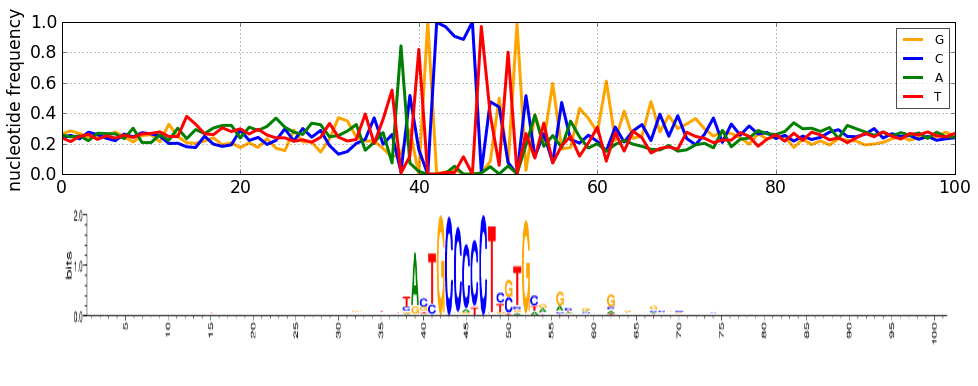

In [8]:
%matplotlib inline
figsize = (16, 6)
fig ,axes = plt.subplots( figsize = figsize , nrows= 2 , ncols=1 )

MEutils.plotSingleNT_marginalDistrib(NTfrequencies= NTcounts / np.sum(NTcounts, axis = 1, keepdims=True).astype(float), 
                                         ax = axes[0])
MEutils.plotSeqLogo(countsArr= NTcounts , 
                    logoFormat = "png" ,
                    webLogoKwargs= {"stacksPerLine" : str( NTcounts.shape[0]) , 
                                    "aspectRatio":  "5" },
                   ax = axes[1], )

The motif output is generated by RWebLogo